In [309]:
from pyspark.sql.functions import col
from pyspark.sql.functions import sum
from pyspark.sql.functions import count
from pyspark.sql import SparkSession
from delta.tables import *
import datetime
import pytz

spark = (
    SparkSession
    .builder
    .appName('Lakehouse_OlhoVivo_Raw_To_Trusted')
    .config('spark.sql.extensions','oi.delta.DeltaSparkSessionExtension')
    .config('spark.sql.catalog.spark_catalog', 'org.apache.spark.sql.delta.catalog.DeltaCatalog')
    .getOrCreate()
)

In [310]:
spark

In [311]:
path_raw = 's3a://raw/olho-vivo/linhas/buscar-linhas/'
path_trusted = 's3a://trusted/olho-vivo/linhas/buscar-linhas/'
print(f"Path RAW: {path_raw}")
print(f"Path TRUSTED: {path_trusted}")

Path RAW: s3a://raw/olho-vivo/linhas/buscar-linhas/
Path TRUSTED: s3a://trusted/olho-vivo/linhas/buscar-linhas/


In [312]:
df_raw = spark.read.json(path_raw)
df_raw.show(5)
df_raw.printSchema()

+-----+-----+----+---+---+----+--------------+
|   cl|   lc|  lt| sl| tl|  tp|            ts|
+-----+-----+----+---+---+----+--------------+
|  412|false|8050|  1| 10|LAPA|PQ. MORRO DOCE|
|33180|false|8050|  2| 10|LAPA|PQ. MORRO DOCE|
|  413|false|8050|  1| 21|LAPA|    ANHANGUERA|
|33181|false|8050|  2| 21|LAPA|    ANHANGUERA|
|  415|false|8050|  1| 31|LAPA|PQ. MORRO DOCE|
+-----+-----+----+---+---+----+--------------+
only showing top 5 rows

root
 |-- cl: long (nullable = true)
 |-- lc: boolean (nullable = true)
 |-- lt: string (nullable = true)
 |-- sl: long (nullable = true)
 |-- tl: long (nullable = true)
 |-- tp: string (nullable = true)
 |-- ts: string (nullable = true)



In [313]:
df_merge = (
    df_raw.select('cl','lc', 'lt', 'tl', 'tp', 'ts')
)
df_merge.show()

+-----+-----+----+---+----+--------------+
|   cl|   lc|  lt| tl|  tp|            ts|
+-----+-----+----+---+----+--------------+
|  412|false|8050| 10|LAPA|PQ. MORRO DOCE|
|33180|false|8050| 10|LAPA|PQ. MORRO DOCE|
|  413|false|8050| 21|LAPA|    ANHANGUERA|
|33181|false|8050| 21|LAPA|    ANHANGUERA|
|  415|false|8050| 31|LAPA|PQ. MORRO DOCE|
|33183|false|8050| 31|LAPA|PQ. MORRO DOCE|
|  412|false|8050| 10|LAPA|PQ. MORRO DOCE|
|33180|false|8050| 10|LAPA|PQ. MORRO DOCE|
|  413|false|8050| 21|LAPA|    ANHANGUERA|
|33181|false|8050| 21|LAPA|    ANHANGUERA|
|  415|false|8050| 31|LAPA|PQ. MORRO DOCE|
|33183|false|8050| 31|LAPA|PQ. MORRO DOCE|
|  412|false|8050| 10|LAPA|PQ. MORRO DOCE|
|33180|false|8050| 10|LAPA|PQ. MORRO DOCE|
|  413|false|8050| 21|LAPA|    ANHANGUERA|
|33181|false|8050| 21|LAPA|    ANHANGUERA|
|  415|false|8050| 31|LAPA|PQ. MORRO DOCE|
|33183|false|8050| 31|LAPA|PQ. MORRO DOCE|
|  412|false|8050| 10|LAPA|PQ. MORRO DOCE|
|33180|false|8050| 10|LAPA|PQ. MORRO DOCE|
+-----+----

In [314]:
total_records = df_merge.count()
print(total_records)

42


In [221]:
#df_merge.write.format('delta').mode('append').save(path_trusted)

+-----+-----+--------------+
|   cl|   lc|            ts|
+-----+-----+--------------+
|  412|false|PQ. MORRO DOCE|
|  413|false|    ANHANGUERA|
|  415|false|PQ. MORRO DOCE|
| 2562|false|  PARAISÓPOLIS|
|33180|false|PQ. MORRO DOCE|
|33181|false|    ANHANGUERA|
|33183|false|PQ. MORRO DOCE|
|35330|false|  PARAISÓPOLIS|
+-----+-----+--------------+



In [315]:
df_trusted = df_merge.select('cl','lc', 'lt', 'tl', 'tp', 'ts').dropDuplicates(['cl'])
df_trusted.show()

if not DeltaTable.isDeltaTable(spark, path_trusted):
    df_trusted.write.format('delta').mode('append').save(path_trusted)
    print('TRUSTED criado com sucesso.')
else:
    print("Delta table already exists.")

+-----+-----+----+---+--------------------+--------------+
|   cl|   lc|  lt| tl|                  tp|            ts|
+-----+-----+----+---+--------------------+--------------+
|  412|false|8050| 10|                LAPA|PQ. MORRO DOCE|
|  413|false|8050| 21|                LAPA|    ANHANGUERA|
|  415|false|8050| 31|                LAPA|PQ. MORRO DOCE|
| 1273|false|8000| 10|PÇA. RAMOS DE AZE...|    TERM. LAPA|
| 1726| true|8020| 10|       SHOP. MORUMBI|       BUTANTÃ|
| 2506|false|8000|  1|PÇA. RAMOS DE AZE...|    TERM. LAPA|
| 2562|false|8030| 10|     TERM. VL. SÔNIA|  PARAISÓPOLIS|
|33180|false|8050| 10|                LAPA|PQ. MORRO DOCE|
|33181|false|8050| 21|                LAPA|    ANHANGUERA|
|33183|false|8050| 31|                LAPA|PQ. MORRO DOCE|
|34041|false|8000| 10|PÇA. RAMOS DE AZE...|    TERM. LAPA|
|34494| true|8020| 10|       SHOP. MORUMBI|       BUTANTÃ|
|35274|false|8000|  1|PÇA. RAMOS DE AZE...|    TERM. LAPA|
|35330|false|8030| 10|     TERM. VL. SÔNIA|  PARAISÓPOLI

In [316]:
delta_table = DeltaTable.forPath(spark, path_trusted)
delta_table.alias('trusted') \
.merge(
            df_trusted.alias('raw'), 'trusted.cl = raw.cl'
    ) \
.whenMatchedUpdate(set = {
    'trusted.lc':col('raw.lc'),
    'trusted.lt':col('raw.lt'),
    'trusted.tl':col('raw.tl'),
    'trusted.tp':col('raw.tp'),
    'trusted.ts':col('raw.ts'),    
    }) \
.whenNotMatchedInsert(values = {
    'trusted.cl':col('raw.cl'),
    'trusted.lc':col('raw.lc'),
    'trusted.lt':col('raw.lt'),
    'trusted.tl':col('raw.tl'),
    'trusted.tp':col('raw.tp'),
    'trusted.ts':col('raw.ts'),
}) \
.execute()
print('MERGE executado com sucesso.')

MERGE executado com sucesso.


In [317]:
df_raw.show(1000)
df_merge.show(1000)
df_trusted.show(1000)

+-----+-----+----+---+---+--------------------+--------------+
|   cl|   lc|  lt| sl| tl|                  tp|            ts|
+-----+-----+----+---+---+--------------------+--------------+
|  412|false|8050|  1| 10|                LAPA|PQ. MORRO DOCE|
|33180|false|8050|  2| 10|                LAPA|PQ. MORRO DOCE|
|  413|false|8050|  1| 21|                LAPA|    ANHANGUERA|
|33181|false|8050|  2| 21|                LAPA|    ANHANGUERA|
|  415|false|8050|  1| 31|                LAPA|PQ. MORRO DOCE|
|33183|false|8050|  2| 31|                LAPA|PQ. MORRO DOCE|
|  412|false|8050|  1| 10|                LAPA|PQ. MORRO DOCE|
|33180|false|8050|  2| 10|                LAPA|PQ. MORRO DOCE|
|  413|false|8050|  1| 21|                LAPA|    ANHANGUERA|
|33181|false|8050|  2| 21|                LAPA|    ANHANGUERA|
|  415|false|8050|  1| 31|                LAPA|PQ. MORRO DOCE|
|33183|false|8050|  2| 31|                LAPA|PQ. MORRO DOCE|
|  412|false|8050|  1| 10|                LAPA|PQ. MORR

In [305]:
print(delta_table.toDF().count())

12


In [318]:
df_deduplicated.select("cl", "lc").show()
df_deduplicated.filter(df_deduplicated.cl == 34494).show()

#SQL queries
df_deduplicated.createOrReplaceTempView("Linhas")
query_result = spark.sql("SELECT cl, lc FROM Linhas WHERE lc = 'true'")
query_result.show()

+-----+-----+
|   cl|   lc|
+-----+-----+
|  415|false|
|  412|false|
|  413|false|
|33180|false|
|33181|false|
|33183|false|
| 2562|false|
|35330|false|
+-----+-----+

+---+---+
| cl| lc|
+---+---+
+---+---+

+---+---+
| cl| lc|
+---+---+
+---+---+



In [307]:
#df_trusted = spark.read.parquet(path_trusted)
df_trusted = spark.read.format('delta').load(path_trusted)
df_trusted.show(1000)



+-----+-----+----+---+--------------------+--------------+
|   cl|   lc|  lt| tl|                  tp|            ts|
+-----+-----+----+---+--------------------+--------------+
|  412|false|8050| 10|                LAPA|PQ. MORRO DOCE|
|  413|false|8050| 21|                LAPA|    ANHANGUERA|
|  415|false|8050| 31|                LAPA|PQ. MORRO DOCE|
| 1273|false|8000| 10|PÇA. RAMOS DE AZE...|    TERM. LAPA|
| 2506|false|8000|  1|PÇA. RAMOS DE AZE...|    TERM. LAPA|
| 2562|false|8030| 10|     TERM. VL. SÔNIA|  PARAISÓPOLIS|
|33180|false|8050| 10|                LAPA|PQ. MORRO DOCE|
|33181|false|8050| 21|                LAPA|    ANHANGUERA|
|33183|false|8050| 31|                LAPA|PQ. MORRO DOCE|
|34041|false|8000| 10|PÇA. RAMOS DE AZE...|    TERM. LAPA|
|35274|false|8000|  1|PÇA. RAMOS DE AZE...|    TERM. LAPA|
|35330|false|8030| 10|     TERM. VL. SÔNIA|  PARAISÓPOLIS|
+-----+-----+----+---+--------------------+--------------+



In [308]:
df_grouped = df_trusted.groupBy("lc").agg(sum("cl").alias("qtd"))
df_grouped.show()
df_grouped = df_trusted.groupBy("lc").agg(count("*").alias("count"))
df_grouped.show()

+-----+------+
|   lc|   qtd|
+-----+------+
|false|211770|
+-----+------+

+-----+-----+
|   lc|count|
+-----+-----+
|false|   12|
+-----+-----+



In [230]:
#lista os arquivos parquet no Minio
from minio import Minio
from io import BytesIO
import pandas as pd

minio_client = Minio(
    "minio:9000",
    access_key="admin",
    secret_key="minioadmin",
    secure=False
)

bucket_name = "trusted"
object_files = [
    obj.object_name for obj in minio_client.list_objects(bucket_name, recursive=True)
    if obj.object_name.endswith(".parquet")]

# loop para ler e imprimir conteudo de cada arquivo
for file in object_files:
    print(f"Lendo arquivo: {file}")
    
#joga o arquivo para memória
    parquet_object = minio_client.get_object(bucket_name, file)
    parquet_data = BytesIO(parquet_object.read())
    
#cria objeto DataFrame(df)
    df = pd.read_parquet(parquet_data, engine="pyarrow")
    
    print(df.head())


    
   

Lendo arquivo: olho-vivo/linhas/buscar-linhas/_delta_log/00000000000000000010.checkpoint.parquet
    txn   add                                             remove metaData  \
0  None  None  {'path': 'part-00000-877ed7c1-87e2-4cf7-8405-d...     None   
1  None  None  {'path': 'part-00000-fbfe46fc-68d5-45c0-becc-9...     None   
2  None  None  {'path': 'part-00000-975b2c68-22f8-4026-b0c8-7...     None   
3  None  None  {'path': 'part-00000-42498faf-978a-4887-ae2b-2...     None   
4  None  None  {'path': 'part-00000-4b65cb73-8f5c-4535-8f17-1...     None   

  protocol  
0     None  
1     None  
2     None  
3     None  
4     None  
Lendo arquivo: olho-vivo/linhas/buscar-linhas/part-00000-42498faf-978a-4887-ae2b-25ed69d7caf3-c000.snappy.parquet
      cl     lc
0    412  False
1    413  False
2    415  False
3   2562  False
4  33180  False
Lendo arquivo: olho-vivo/linhas/buscar-linhas/part-00000-47f653b0-c655-499b-85f9-78fb73f62438-c000.snappy.parquet
      cl     lc
0    415  False
1    4

In [266]:
path_raw = 's3a://raw/olho-vivo/paradas/buscar-paradas-por-linha/'
path_trusted = 's3a://trusted/olho-vivo/paradas/buscar-paradas-por-linha/'
print(f"Path RAW: {path_raw}")
print(f"Path TRUSTED: {path_trusted}")

Path RAW: s3a://raw/olho-vivo/paradas/buscar-paradas-por-linha/
Path TRUSTED: s3a://trusted/olho-vivo/paradas/buscar-paradas-por-linha/


In [267]:
df_raw = spark.read.json(path_raw)
df_raw.show(5)

+--------+--------------------+--------------------+----------+----------+
|      cp|                  ed|                  np|        px|        py|
+--------+--------------------+--------------------+----------+----------+
|  614432|   R   PEDRO MACHADO|    BABY BARIONY C/B|-46.671511|-23.527608|
| 7014416|R DR.  ALBUQUERQU...|        ANGELICA C/B|-46.654322|-23.534377|
|60014604|VDTO POMPEIA/ R J...|    SESC POMPEIA C/B|-46.682254|-23.525262|
|60016783|R PADRE ANTONIO T...|PARADA PALMEIRAS C/B|-46.679493|-23.525653|
|60016785|R ENGENHEIRO STEV...|       ANTARTICA C/B|-46.674187| -23.52622|
+--------+--------------------+--------------------+----------+----------+
only showing top 5 rows



In [268]:
df_raw.printSchema()

root
 |-- cp: long (nullable = true)
 |-- ed: string (nullable = true)
 |-- np: string (nullable = true)
 |-- px: double (nullable = true)
 |-- py: double (nullable = true)



In [269]:
df_paradas = (
    df_raw.select('cp','ed', 'np', 'px', 'py')
)
df_paradas.show()

+---------+--------------------+--------------------+----------+----------+
|       cp|                  ed|                  np|        px|        py|
+---------+--------------------+--------------------+----------+----------+
|   614432|   R   PEDRO MACHADO|    BABY BARIONY C/B|-46.671511|-23.527608|
|  7014416|R DR.  ALBUQUERQU...|        ANGELICA C/B|-46.654322|-23.534377|
| 60014604|VDTO POMPEIA/ R J...|    SESC POMPEIA C/B|-46.682254|-23.525262|
| 60016783|R PADRE ANTONIO T...|PARADA PALMEIRAS C/B|-46.679493|-23.525653|
| 60016785|R ENGENHEIRO STEV...|       ANTARTICA C/B|-46.674187| -23.52622|
| 60016789|R DONA GERMAINE B...|PQ. DA ÁGUA BRANC...|-46.667777|-23.529636|
|480012878|R ANTONIO SARKIS/...|        MARGINAL C/B|-46.705402|-23.510894|
|480012879|R ANTONIO SARKIS/...|    MARGINAL C/B LAT|-46.705329|-23.510873|
|480012882|R BELCHIOR CARNEI...|      JOSE MARIA C/B|-46.702881| -23.51367|
|480012942|R NICOLAU PERRONE...|         ZANELLA C/B|-46.698513| -23.51644|
|480014608| 

In [273]:
df_trusted = df_paradas.select('cp', 'ed', 'np', 'px', 'py').dropDuplicates(['cp'])
df_trusted.show()

if not DeltaTable.isDeltaTable(spark, path_trusted):
    df_trusted.write.format('delta').mode('append').save(path_trusted)
    print('TRUSTED criado com sucesso.')
else:
    print("Delta table already exists.")

+---------+--------------------+--------------------+----------+----------+
|       cp|                  ed|                  np|        px|        py|
+---------+--------------------+--------------------+----------+----------+
|   614432|   R   PEDRO MACHADO|    BABY BARIONY C/B|-46.671511|-23.527608|
|  7014416|R DR.  ALBUQUERQU...|        ANGELICA C/B|-46.654322|-23.534377|
| 60014604|VDTO POMPEIA/ R J...|    SESC POMPEIA C/B|-46.682254|-23.525262|
| 60016783|R PADRE ANTONIO T...|PARADA PALMEIRAS C/B|-46.679493|-23.525653|
| 60016785|R ENGENHEIRO STEV...|       ANTARTICA C/B|-46.674187| -23.52622|
| 60016789|R DONA GERMAINE B...|PQ. DA ÁGUA BRANC...|-46.667777|-23.529636|
|260015039|AV PAULISTA/ AV R...|        PAULISTA B/C| -46.66306|-23.555883|
|260016857|R CORONEL JOSE EU...|    PEDRO TAQUES B/C|-46.657399|-23.551843|
|260016859|R DONA ANTONIA DE...|ANTÔNIA DE QUEIRÓ...|-46.653216|-23.549577|
|260016861|R MARQUES DE PARA...|      CAIO PRADO B/C|-46.649565|-23.548174|
|480012878|R

In [274]:
delta_table = DeltaTable.forPath(spark, path_trusted)
delta_table.alias('trusted') \
.merge(
            df_trusted.alias('raw'), 'trusted.cp = raw.cp'
    ) \
.whenMatchedUpdate(set = {
    'trusted.ed':col('raw.ed'),
    }) \
.whenNotMatchedInsert(values = {
    'trusted.cp':col('raw.cp'),
    'trusted.ed':col('raw.ed'),
}) \
.execute()
print('MERGE executado com sucesso.')

MERGE executado com sucesso.


In [239]:
path_raw = 's3a://raw/olho-vivo/posicao-veiculos/buscar-posicao/'
path_trusted = 's3a://trusted/olho-vivo/posicao-veiculos/buscar-posicao/'
print(f"Path RAW: {path_raw}")
print(f"Path TRUSTED: {path_trusted}")

Path RAW: s3a://raw/olho-vivo/posicao-veiculos/buscar-posicao/
Path TRUSTED: s3a://trusted/olho-vivo/posicao-veiculos/buscar-posicao/


In [232]:
from pyspark.sql import functions as F
df_raw = spark.read.json(path_raw)
df_select_L = df_raw.select(F.explode(df_raw["l"]).alias("l"))
df_select_VS = df_select_L.select(
    "l.c",
    "l.cl",
    "l.sl", 
    "l.lt0",
    "l.lt1",
    "l.qv",
    F.explode("l.vs").alias("vs")
)

df_vs = df_select_VS.select(
    "c",
    "cl",
    "sl",
    "lt0", 
    "lt1", 
    "qv",
    F.col("vs.p").alias("vs_p"),
    F.col("vs.a").alias("vs_a"),
    F.col("vs.ta").alias("vs_ta"),
    F.col("vs.py").alias("vs_py"),
    F.col("vs.px").alias("vs_px"),
    F.col("vs.sv").alias("vs_sv"),
    F.col("vs.is").alias("vs_is"),
)

#df_select_VS.show(5)
df_vs.show(5)

+-------+-----+---+------------------+--------------+---+-----+----+--------------------+------------+------------+-----+-----+
|      c|   cl| sl|               lt0|           lt1| qv| vs_p|vs_a|               vs_ta|       vs_py|       vs_px|vs_sv|vs_is|
+-------+-----+---+------------------+--------------+---+-----+----+--------------------+------------+------------+-----+-----+
|7002-10|33540|  2|HOSP. DAS CLÍNICAS|JD. ROSA MARIA|  4|86347|true|2025-02-03T01:03:54Z|  -23.590518|-46.76971475| null| null|
|7002-10|33540|  2|HOSP. DAS CLÍNICAS|JD. ROSA MARIA|  4|86153|true|2025-02-03T01:03:52Z|  -23.590518|-46.76971475| null| null|
|7002-10|33540|  2|HOSP. DAS CLÍNICAS|JD. ROSA MARIA|  4|86077|true|2025-02-03T01:04:14Z|  -23.590518|-46.76971475| null| null|
|7002-10|33540|  2|HOSP. DAS CLÍNICAS|JD. ROSA MARIA|  4|86327|true|2025-02-03T01:04:06Z|-23.56891275|-46.69930325| null| null|
|6048-10|   56|  1|        STO. AMARO| CAPÃO REDONDO|  1|71652|true|2025-02-03T01:04:02Z|  -23.658084|-4

In [233]:
df_posicao = (
    df_vs.select('vs_p','cl', 'c')
)
df_posicao.show()

+-----+-----+-------+
| vs_p|   cl|      c|
+-----+-----+-------+
|86347|33540|7002-10|
|86153|33540|7002-10|
|86077|33540|7002-10|
|86327|33540|7002-10|
|71652|   56|6048-10|
|55359|34398|573H-10|
|55094|34398|573H-10|
|55193|34398|573H-10|
|55223|34398|573H-10|
|45570|33794|3729-10|
|45355|33794|3729-10|
|45421|33794|3729-10|
|45434|33794|3729-10|
|85687|33564|775F-10|
|85697|33564|775F-10|
|85592|33564|775F-10|
|85679|33564|775F-10|
|45400|  939|2725-10|
|45258|  939|2725-10|
|45195|  939|2725-10|
+-----+-----+-------+
only showing top 20 rows



In [240]:
df_trusted = df_posicao.select('vs_p', 'cl', 'c').dropDuplicates(['cl'])
df_trusted.show()

if not DeltaTable.isDeltaTable(spark, path_trusted):
    df_trusted.write.format('delta').mode('append').save(path_trusted)
    print('TRUSTED criado com sucesso.')
else:
    print("Delta table already exists.")

+-----+---+-------+
| vs_p| cl|      c|
+-----+---+-------+
|71255|  1|5119-10|
|75503|  4|669A-10|
|72917|  5|6801-10|
|85617|  6|6837-10|
|72771| 12|6835-10|
|72769| 13|6836-10|
|72007| 14|6825-10|
|72568| 16|6826-10|
|72573| 19|6820-10|
|72582| 21|6821-10|
|72770| 23|6824-10|
|72563| 26|6816-10|
|72577| 28|6818-10|
|72570| 29|6803-10|
|72761| 30|6804-10|
|72391| 31|6805-10|
|72765| 32|6806-10|
|72055| 33|6813-10|
|72940| 34|6823-10|
|71863| 37|609F-10|
+-----+---+-------+
only showing top 20 rows

TRUSTED criado com sucesso.


In [238]:
#df_deduplicated.select("cl", "lc").show()
#df_deduplicated.filter(df_deduplicated.cl == 34494).show()

#SQL queries
df_trusted.createOrReplaceTempView("PosicaoVeiculos")
query_result = spark.sql("SELECT * FROM PosicaoVeiculos")
query_result.show()

+-----+---+-------+
| vs_p| cl|      c|
+-----+---+-------+
|71255|  1|5119-10|
|75503|  4|669A-10|
|72917|  5|6801-10|
|85617|  6|6837-10|
|72771| 12|6835-10|
|72769| 13|6836-10|
|72007| 14|6825-10|
|72568| 16|6826-10|
|72573| 19|6820-10|
|72582| 21|6821-10|
|72770| 23|6824-10|
|72563| 26|6816-10|
|72577| 28|6818-10|
|72570| 29|6803-10|
|72761| 30|6804-10|
|72391| 31|6805-10|
|72765| 32|6806-10|
|72055| 33|6813-10|
|72940| 34|6823-10|
|71863| 37|609F-10|
+-----+---+-------+
only showing top 20 rows



In [254]:
#GTFS
path_raw = 's3a://raw/gtfs/fare_attributes.txt'
print(f"Path GTFS RAW: {path_raw}")

Path GTFS RAW: s3a://raw/gtfs/fare_attributes.txt


In [255]:
df_raw = spark.read.option("header", "true").option(",", "true").csv(path_raw)
df_raw.show(1000)

+--------------------+---------+-------------+--------------+---------+-----------------+
|             fare_id|    price|currency_type|payment_method|transfers|transfer_duration|
+--------------------+---------+-------------+--------------+---------+-----------------+
|                CPTM| 5.200000|          BRL|             0|     null|            10800|
|               Metrô| 5.200000|          BRL|             0|     null|            10800|
|              Ônibus| 5.000000|          BRL|             0|     null|            10800|
|       Ônibus + CPTM| 8.900000|          BRL|             0|     null|            10800|
|      Ônibus + Metrô| 8.900000|          BRL|             0|     null|            10800|
|Ônibus + Metrô + ...|13.900000|          BRL|             0|     null|            10800|
+--------------------+---------+-------------+--------------+---------+-----------------+



In [ ]:
#converter para parquet
#df_raw.write.mode("overwrite").parquet("s3a://meu-bucket/dados/")

In [262]:
import pandas as pd

df_pandas = df_raw.toPandas()
display(df_pandas)  # Alternativa ao df_pandas.head()


fare_id      price currency_type payment_method transfers  \
0                   CPTM   5.200000           BRL              0      None   
1                  Metrô   5.200000           BRL              0      None   
2                 Ônibus   5.000000           BRL              0      None   
3          Ônibus + CPTM   8.900000           BRL              0      None   
4         Ônibus + Metrô   8.900000           BRL              0      None   
5  Ônibus + Metrô + CPTM  13.900000           BRL              0      None   

  transfer_duration  
0             10800  
1             10800  
2             10800  
3             10800  
4             10800  
5             10800

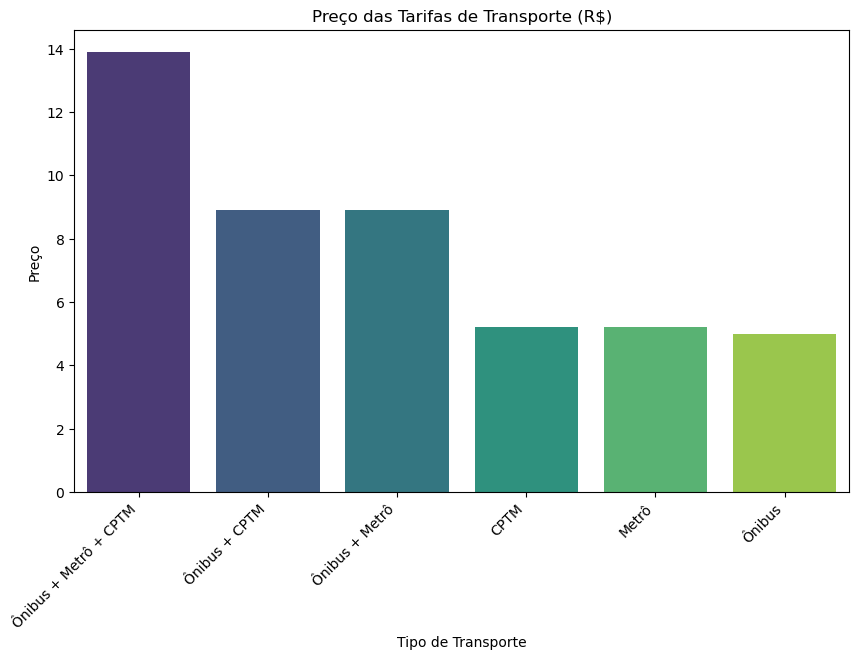

In [265]:
import seaborn as sns
import matplotlib.pyplot as plt

#conversao Pandas
df_pandas = df_raw.toPandas()
df_pandas["price"] = df_pandas["price"].astype(float)
df_pandas = df_pandas.sort_values(by="price", ascending=False)

#bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=df_pandas, x="fare_id", y="price", palette="viridis")

# colors
plt.xticks(rotation=45, ha="right")
plt.xlabel("Tipo de Transporte")
plt.ylabel("Preço")
plt.title("Preço das Tarifas de Transporte (R$)")

plt.show()
